# 1d Conv on EEG data

Start with simple models
1. Linear model (LIN)
2. Multi Layer Perceptron Model (MLP)
3. Convolutional Model (CNN)

In [1]:
import sys
sys.path.append('../')

In [2]:
from utils.dataset import EEGDataset
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


eeg_dir = Path('../EEGDataset/raw')
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

data = EEGDataset(eeg_dir, subjects)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [3]:
def train(dataloader, model, loss_fn, optimizer, device='cpu', clip=None):
    model.train()

    tra_loss = 0
    for batch in dataloader:
        X = batch['eeg'].to(device)
        y = batch['label'].to(device)

        # compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clip is not None:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)   
        optimizer.step()

        tra_loss += loss.item() * len(batch)

    tra_loss /= len(dataloader.dataset)

    return tra_loss

def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch['eeg'].to(device)
            y = batch['label'].to(device)

            pred = model(X).squeeze()
            val_loss += loss_fn(pred, y).item() * len(batch)
            correct += ((pred>0.5) == y).type(torch.float).sum().item()
    val_loss /= size
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss     

### 1. Linear model

In [7]:
from utils.models import LIN
from utils.transforms import Compose, Flatten, ToTensor, EEGStandardScaler
from torch.utils.data import random_split, DataLoader 

# Training parameters
batch_size = 32
lr = 0.001
epochs = 10

# data 
data.transform = Compose([Flatten(), ToTensor()])
trainset, valset, testset = random_split(data, [0.7, 0.1, 0.2])

# Standardize
scaler = EEGStandardScaler(trainset)
data.transform = Compose([Flatten(), ToTensor(), scaler])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=32)
test_loader  = DataLoader(testset, batch_size=batch_size)

# model
sample = data[0]['eeg']
input_size = sample.shape[0]
model = LIN(input_size).to(device)

print('Number of parameters: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

Number of parameters:  19329


In [8]:
model.parameters

<bound method Module.parameters of LIN(
  (lin): Linear(in_features=19328, out_features=1, bias=True)
  (sig): Sigmoid()
)>

In [9]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------
Error: 
 Accuracy: 68.8%, Avg loss: 3.326084 

Epoch 2
-------------------------------
Error: 
 Accuracy: 76.6%, Avg loss: 3.254754 

Epoch 3
-------------------------------
Error: 
 Accuracy: 76.4%, Avg loss: 3.253860 

Epoch 4
-------------------------------
Error: 
 Accuracy: 73.0%, Avg loss: 3.286029 

Epoch 5
-------------------------------
Error: 
 Accuracy: 75.3%, Avg loss: 3.263680 

Epoch 6
-------------------------------
Error: 
 Accuracy: 78.0%, Avg loss: 3.239455 

Epoch 7
-------------------------------
Error: 
 Accuracy: 79.3%, Avg loss: 3.233769 

Epoch 8
-------------------------------
Error: 
 Accuracy: 78.2%, Avg loss: 3.232650 

Epoch 9
-------------------------------
Error: 
 Accuracy: 78.9%, Avg loss: 3.238552 

Epoch 10
-------------------------------
Error: 
 Accuracy: 78.7%, Avg loss: 3.228452 

Done!


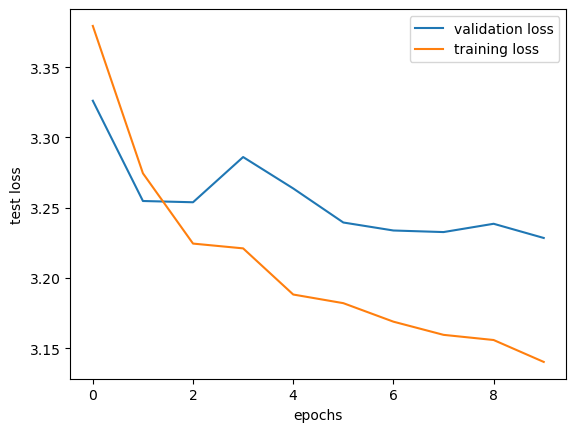

In [10]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [11]:
print('Train ') 
valid(train_loader, model, loss_fn, device=device)

print('Validation ')
valid(val_loader, model, loss_fn, device=device)

print('Test ')
valid(test_loader, model, loss_fn, device=device)

Train 
Error: 
 Accuracy: 94.0%, Avg loss: 3.136029 

Validation 
Error: 
 Accuracy: 84.2%, Avg loss: 3.583610 

Test 
Error: 
 Accuracy: 78.7%, Avg loss: 3.228452 



3.228452103861262

### 2. Multi Layer Perceptron

In [21]:
from utils.models import MLP
from utils.transforms import Compose, Flatten, ToTensor, EEGStandardScaler
from torch.utils.data import random_split, DataLoader 

# Training parameters
batch_size = 32
lr = 0.0001
epochs = 50

# data 
data.transform = Compose([Flatten(), ToTensor()])
trainset, valset, testset = random_split(data, [0.7, 0.1, 0.2])

# standardize
scaler = EEGStandardScaler(trainset)
data.transform = Compose([Flatten(), ToTensor(), scaler])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=32)
test_loader  = DataLoader(testset, batch_size=batch_size)

# model
sample = data[0]['eeg']
input_size = sample.shape[0]
model = MLP(input_size).to(device)

print('Number of parameters: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

Number of parameters:  2490753


In [22]:
model.parameters

<bound method Module.parameters of MLP(
  (input): Sequential(
    (0): Linear(in_features=19328, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

In [23]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device, clip=None))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------
Error: 
 Accuracy: 73.9%, Avg loss: 3.089963 

Epoch 2
-------------------------------
Error: 
 Accuracy: 72.6%, Avg loss: 3.069190 

Epoch 3
-------------------------------
Error: 
 Accuracy: 75.1%, Avg loss: 3.050856 

Epoch 4
-------------------------------
Error: 
 Accuracy: 78.2%, Avg loss: 3.033255 

Epoch 5
-------------------------------
Error: 
 Accuracy: 77.8%, Avg loss: 3.031229 

Epoch 6
-------------------------------
Error: 
 Accuracy: 78.4%, Avg loss: 3.025073 

Epoch 7
-------------------------------
Error: 
 Accuracy: 80.4%, Avg loss: 3.012783 

Epoch 8
-------------------------------
Error: 
 Accuracy: 78.7%, Avg loss: 3.017704 

Epoch 9
-------------------------------
Error: 
 Accuracy: 80.4%, Avg loss: 3.014214 

Epoch 10
-------------------------------
Error: 
 Accuracy: 80.4%, Avg loss: 3.013413 

Epoch 11
-------------------------------
Error: 
 Accuracy: 84.0%, Avg loss: 2.994179 

Epoch 12
-------------------------------


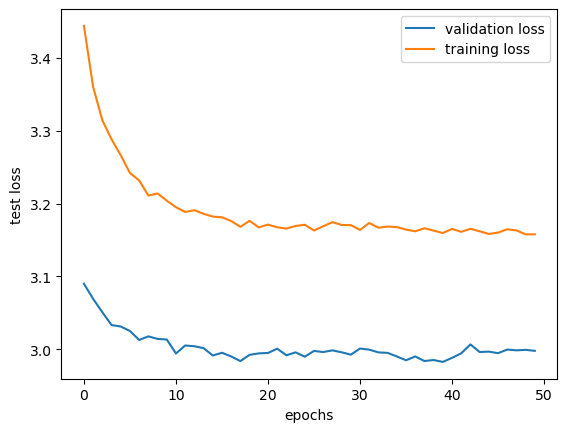

In [24]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [25]:
print('Train ') 
valid(train_loader, model, loss_fn, device=device)

print('Validation ')
valid(val_loader, model, loss_fn, device=device)

print('Test ')
valid(test_loader, model, loss_fn, device=device)

Train 
Error: 
 Accuracy: 99.6%, Avg loss: 3.154359 

Validation 
Error: 
 Accuracy: 82.9%, Avg loss: 3.464337 

Test 
Error: 
 Accuracy: 82.5%, Avg loss: 2.997829 



2.997828751467587

### 3. Convolutional Model

In [4]:
from utils.models import CNN
from utils.transforms import ToTensor, Compose, EEGStandardScaler
from torch.utils.data import random_split, DataLoader

# Training parameters
batch_size = 32
lr = 0.005
epochs = 100

# data 
data.transform = Compose([ToTensor()])
trainset, valset, testset = random_split(data, [0.7, 0.1, 0.2])

# standardize
scaler = EEGStandardScaler(trainset)
data.transform = Compose([ToTensor(), scaler])

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32)
test_loader = DataLoader(testset, batch_size=32)

# model
sample = data[0]['eeg']
n_channels = sample.shape[0]
n_kernels = 8

model = CNN(n_channels, n_kernels).to(device)
#model.init_weights()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

41521


In [5]:
model.parameters

<bound method Module.parameters of CNN(
  (conv1d): Sequential(
    (0): Conv1d(1, 8, kernel_size=(32,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (encode): Sequential(
    (0): Linear(in_features=1024, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (pool): AvgPool2d(kernel_size=(1, 32), stride=(1, 16), padding=0)
  (output): Sequential(
    (0): Linear(in_features=240, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

In [6]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device, clip=0.1))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------


/tmp/ipykernel_25144/38503656.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)


Error: 
 Accuracy: 77.5%, Avg loss: 3.258611 

Epoch 2
-------------------------------
Error: 
 Accuracy: 78.9%, Avg loss: 3.251354 

Epoch 3
-------------------------------
Error: 
 Accuracy: 79.1%, Avg loss: 3.229810 

Epoch 4
-------------------------------
Error: 
 Accuracy: 79.1%, Avg loss: 3.227779 

Epoch 5
-------------------------------
Error: 
 Accuracy: 81.8%, Avg loss: 3.211101 

Epoch 6
-------------------------------
Error: 
 Accuracy: 86.1%, Avg loss: 3.185128 

Epoch 7
-------------------------------
Error: 
 Accuracy: 85.8%, Avg loss: 3.188533 

Epoch 8
-------------------------------
Error: 
 Accuracy: 84.3%, Avg loss: 3.190296 

Epoch 9
-------------------------------
Error: 
 Accuracy: 83.1%, Avg loss: 3.193318 

Epoch 10
-------------------------------
Error: 
 Accuracy: 84.7%, Avg loss: 3.193704 

Epoch 11
-------------------------------
Error: 
 Accuracy: 85.6%, Avg loss: 3.191650 

Epoch 12
-------------------------------
Error: 
 Accuracy: 84.7%, Avg loss: 3.18

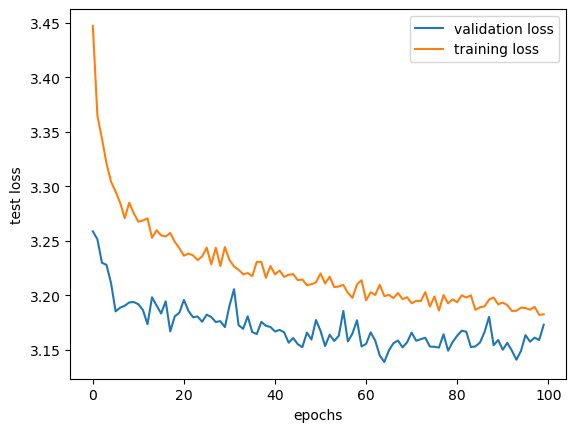

In [7]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [8]:
print('Train ') 
valid(train_loader, model, loss_fn, device=device)

print('Validation ')
valid(val_loader, model, loss_fn, device=device)

print('Test ')
valid(test_loader, model, loss_fn, device=device)

Train 
Error: 
 Accuracy: 99.0%, Avg loss: 3.173821 

Validation 
Error: 
 Accuracy: 88.7%, Avg loss: 2.910884 

Test 
Error: 
 Accuracy: 87.9%, Avg loss: 3.172916 



3.172915803716424